# Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers, backend as K, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import glob

### load data

In [2]:
# Load array
x_train = np.load('driven_damped_pendulum_data_train.npy')
x_val = np.load('driven_damped_pendulum_data_valid.npy')
x_test = np.load('driven_damped_pendulum_data_test.npy')

kappas_tr, betas_tr, As_tr, omegas_tr = np.loadtxt('driven_damped_pendulum_data_params_train.dat', unpack=True)
kappas_va, betas_va, As_va, omegas_va = np.loadtxt('driven_damped_pendulum_data_params_valid.dat', unpack=True)
kappas_te, betas_te, As_te, omegas_te = np.loadtxt('driven_damped_pendulum_data_params_test.dat', unpack=True)

rtimes_tr = np.load('rtimes_tr_driven.npy')
rtimes_va = np.load('rtimes_va_driven.npy')
rtimes_te = np.load('rtimes_te_driven.npy')

answers_tr = np.load('answers_tr_driven.npy')
answers_va = np.load('answers_va_driven.npy')
answers_te = np.load('answers_te_driven.npy')

In [3]:
rtimes_tr = rtimes_tr.T
rtimes_va = rtimes_va.T
rtimes_te = rtimes_te.T

answers_tr = answers_tr.T
answers_va = answers_va.T
answers_te = answers_te.T

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Neural Network

In [5]:
num_hidden_layers = 2
encoding_dim = 5
input_dim = x_train.shape[1]
hidden_dim = 100
batch_size = 512
epochs = 1000
learning_rate = 0.001
regul=0.0
regul2=0.0

factor = 0.25
patience = 50
min_lr = 0.000001
verbose = 1

beta = 2

In [6]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_total_loss',
                                                 factor=factor,
                                                 patience=patience, 
                                                 min_lr=min_lr, 
                                                 verbose=verbose
                                                )

In [7]:
early_stopping_callback = EarlyStopping(
    patience=patience,
    monitor='val_total_loss',
    mode='min',
    verbose=verbose
)

## Autoencoder

In [8]:
encoder_input = keras.Input(shape=(input_dim,))
rtimes_input = keras.Input(shape=(1,))

#encoder 
x = layers.Dense(5*hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(encoder_input)
for i in range(num_hidden_layers):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
z_mean = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)
z_log_var = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)

z = Sampling()([z_mean, z_log_var])

decoder_input = keras.Input(shape=(encoding_dim+1,)) #1 -> question

#decoder
x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(decoder_input)
for i in range(num_hidden_layers-1):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
x = layers.Dense(5*hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
decoded = layers.Dense(1, activation='linear')(x)

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
decoder = keras.Model(decoder_input, decoded, name='decoder')

# autoencoder = keras.Model([encoder_input, rtimes_input], decoder(tf.concat(values=[encoder(encoder_input)[2], rtimes_input], axis=1)))

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='recon_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            [x_train, rtimes_tr], answers_tr = data
            z_mean, z_log_var, z = self.encoder(x_train)
            dec_inp = tf.concat(values=[z, rtimes_tr], axis=1)
            reconstruction = self.decoder(dec_inp)
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(answers_tr, reconstruction),
                    axis=(-1))) # , 2
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = recon_loss + (beta * kl_loss)
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(recon_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "total_loss": self.total_loss_tracker.result(),
                "recon_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }
        
    def test_step(self, data):
        [x_test, rtimes_te], answers_te = data
        z_mean, z_log_var, z = self.encoder(x_test)
        dec_inp = tf.concat(values=[z, rtimes_te], axis=1)
        reconstruction = self.decoder(dec_inp)
        recon_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mse(answers_te, reconstruction),
                axis=(-1))) # , 2
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = recon_loss + (beta * kl_loss)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "recon_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), run_eagerly=True)

## training the model

In [11]:
fitting_output = vae.fit([x_train, rtimes_tr], answers_tr,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=([x_val, rtimes_va], answers_va),
                          callbacks=[reduce_lr, early_stopping_callback])

Epoch 1/1000
28/28 [==============================] - 2s 85ms/step - total_loss: 511.2431 - recon_loss: 510.4083 - kl_loss: 0.4174 - val_total_loss: 903.1665 - val_recon_loss: 902.4196 - val_kl_loss: 0.3735 - lr: 0.0010
Epoch 2/1000
28/28 [==============================] - 2s 77ms/step - total_loss: 485.8755 - recon_loss: 484.8344 - kl_loss: 0.5206 - val_total_loss: 928.1348 - val_recon_loss: 927.3138 - val_kl_loss: 0.4105 - lr: 0.0010
Epoch 3/1000
28/28 [==============================] - 3s 107ms/step - total_loss: 486.1234 - recon_loss: 485.1983 - kl_loss: 0.4626 - val_total_loss: 921.6008 - val_recon_loss: 920.6151 - val_kl_loss: 0.4928 - lr: 0.0010
Epoch 4/1000
28/28 [==============================] - 2s 79ms/step - total_loss: 481.3499 - recon_loss: 480.2239 - kl_loss: 0.5630 - val_total_loss: 909.8989 - val_recon_loss: 908.1780 - val_kl_loss: 0.8605 - lr: 0.0010
Epoch 5/1000
28/28 [==============================] - 2s 69ms/step - total_loss: 466.7375 - recon_loss: 464.4107 - kl_l

28/28 [==============================] - 2s 86ms/step - total_loss: 418.6100 - recon_loss: 412.2099 - kl_loss: 3.2001 - val_total_loss: 824.0587 - val_recon_loss: 816.9915 - val_kl_loss: 3.5336 - lr: 0.0010
Epoch 39/1000
28/28 [==============================] - 2s 84ms/step - total_loss: 442.4091 - recon_loss: 436.2583 - kl_loss: 3.0754 - val_total_loss: 861.5839 - val_recon_loss: 855.9999 - val_kl_loss: 2.7920 - lr: 0.0010
Epoch 40/1000
28/28 [==============================] - 2s 63ms/step - total_loss: 417.9638 - recon_loss: 412.5063 - kl_loss: 2.7288 - val_total_loss: 929.4498 - val_recon_loss: 923.9598 - val_kl_loss: 2.7450 - lr: 0.0010
Epoch 41/1000
28/28 [==============================] - 2s 68ms/step - total_loss: 398.9697 - recon_loss: 393.1936 - kl_loss: 2.8880 - val_total_loss: 834.9025 - val_recon_loss: 829.0743 - val_kl_loss: 2.9141 - lr: 0.0010
Epoch 42/1000
28/28 [==============================] - 2s 66ms/step - total_loss: 338.6729 - recon_loss: 332.9515 - kl_loss: 2.860

In [12]:
training_history = fitting_output.history

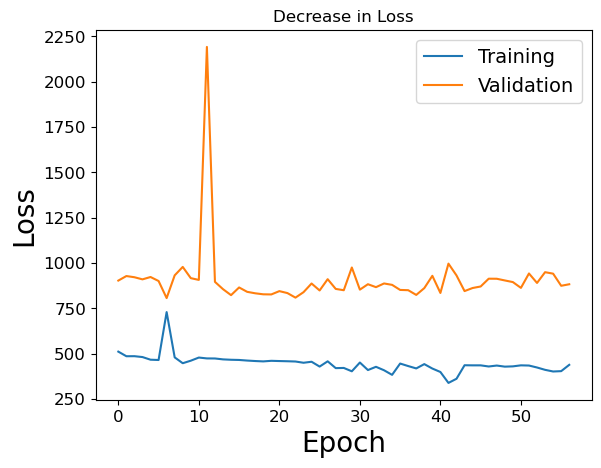

In [13]:
# plotting the decrease in loss as the network learns
fig_loss = plt.figure()
ax = fig_loss.add_subplot(111)
ax.plot(fitting_output.history['total_loss'], label='Training')
ax.plot(fitting_output.history['val_total_loss'], label='Validation')
ax.set_title('Decrease in Loss')
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
# ax.set_xticks(np.arange(0, epochs, 1))
# ax.set_ylim(0, 25)
plt.show()

## testing the model

In [14]:
# compare autoencoder model to encoder and decoder models

# f1 = autoencoder.predict([x_test, rtimes_te])
f2 = decoder(np.concatenate((encoder(x_test)[2].numpy(), rtimes_te), axis=1))

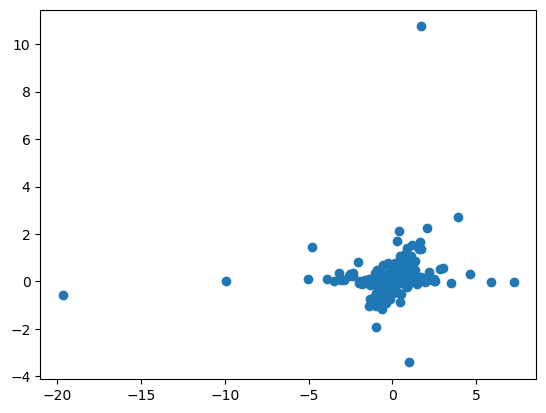

In [15]:
# plt.plot(answers_te, f1, 'o')
plt.plot(answers_te, f2, 'o')

In [16]:
encoded_data = encoder(x_test)[2]

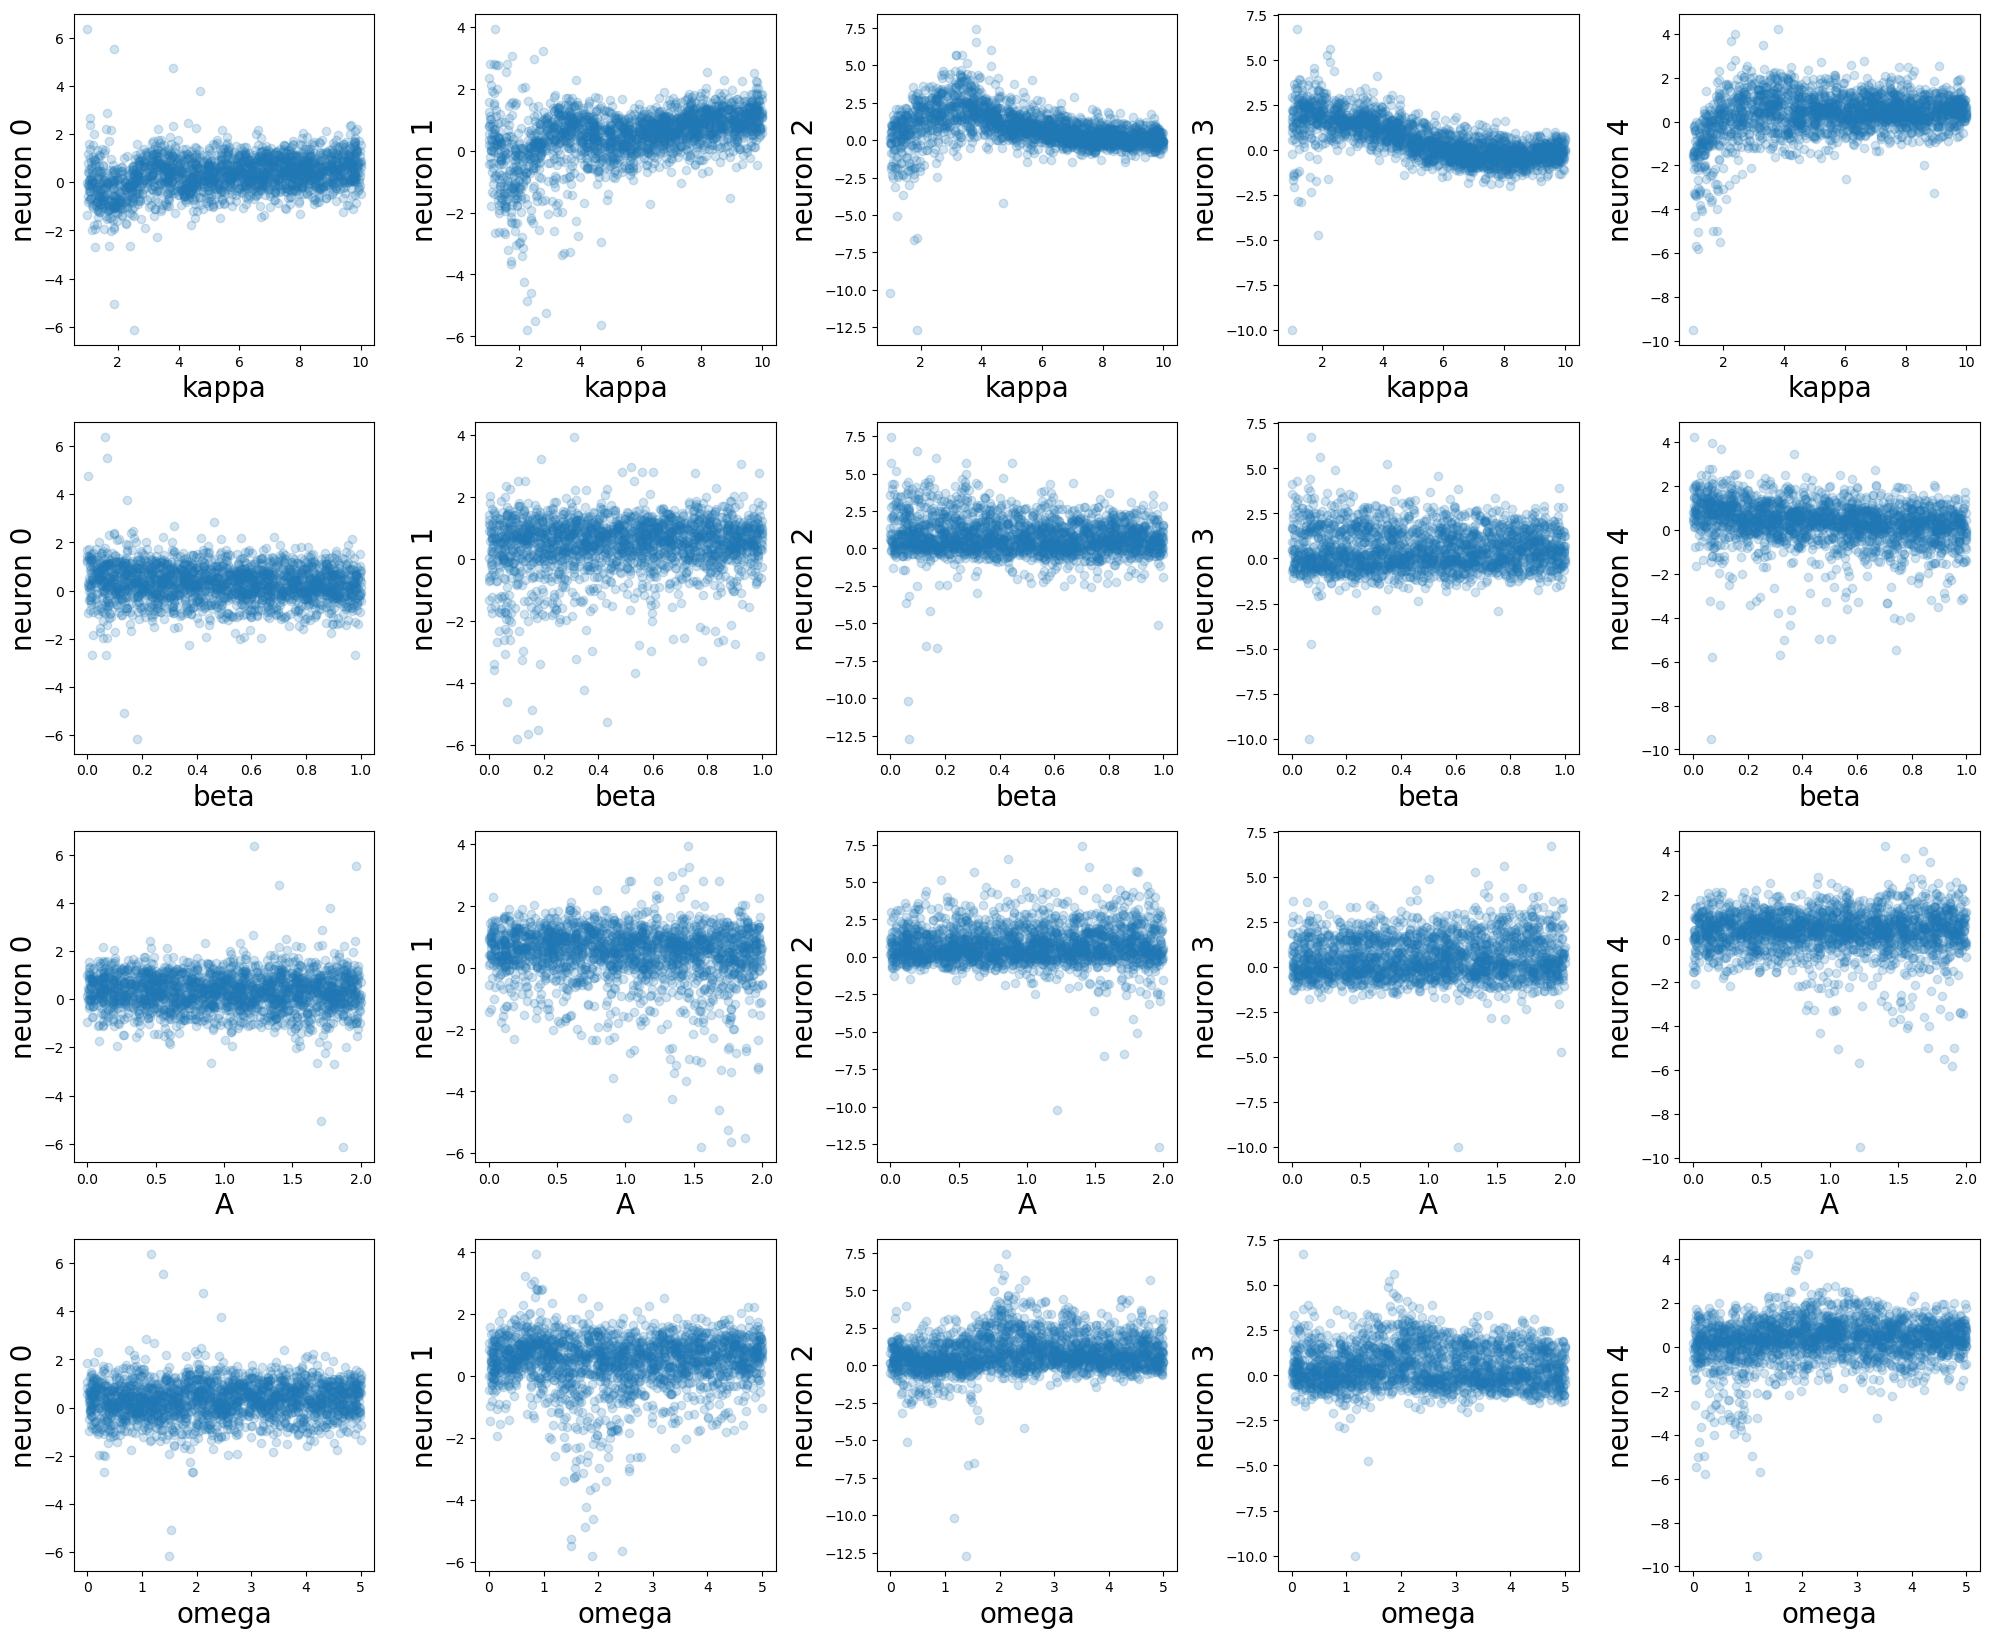

In [17]:
fig = plt.figure(figsize=(20, 20))

fontsize = 20

# Kappa plots
ax1 = fig.add_subplot(551)
ax1.plot(kappas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax1.set_xlabel('kappa', fontsize=fontsize)
ax1.set_ylabel('neuron 0', fontsize=fontsize)

ax2 = fig.add_subplot(552)
ax2.plot(kappas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax2.set_xlabel('kappa', fontsize=fontsize)
ax2.set_ylabel('neuron 1', fontsize=fontsize)

ax3 = fig.add_subplot(553)
ax3.plot(kappas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax3.set_xlabel('kappa', fontsize=fontsize)
ax3.set_ylabel('neuron 2', fontsize=fontsize)

ax4 = fig.add_subplot(554)
ax4.plot(kappas_te, encoded_data[:, 3], 'o', alpha=0.2)
ax4.set_xlabel('kappa', fontsize=fontsize)
ax4.set_ylabel('neuron 3', fontsize=fontsize)

ax5 = fig.add_subplot(555)
ax5.plot(kappas_te, encoded_data[:, 4], 'o', alpha=0.2)
ax5.set_xlabel('kappa', fontsize=fontsize)
ax5.set_ylabel('neuron 4', fontsize=fontsize)

# Beta plots
ax6 = fig.add_subplot(556)
ax6.plot(betas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax6.set_xlabel('beta', fontsize=fontsize)
ax6.set_ylabel('neuron 0', fontsize=fontsize)

ax7 = fig.add_subplot(557)
ax7.plot(betas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax7.set_xlabel('beta', fontsize=fontsize)
ax7.set_ylabel('neuron 1', fontsize=fontsize)

ax8 = fig.add_subplot(558)
ax8.plot(betas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax8.set_xlabel('beta', fontsize=fontsize)
ax8.set_ylabel('neuron 2', fontsize=fontsize)

ax9 = fig.add_subplot(559)
ax9.plot(betas_te, encoded_data[:, 3], 'o', alpha=0.2)
ax9.set_xlabel('beta', fontsize=fontsize)
ax9.set_ylabel('neuron 3', fontsize=fontsize)

ax10 = fig.add_subplot(5, 5, 10)
ax10.plot(betas_te, encoded_data[:, 4], 'o', alpha=0.2)
ax10.set_xlabel('beta', fontsize=fontsize)
ax10.set_ylabel('neuron 4', fontsize=fontsize)

# A plots
ax11 = fig.add_subplot(5, 5, 11)
ax11.plot(As_te, encoded_data[:, 0], 'o', alpha=0.2)
ax11.set_xlabel('A', fontsize=fontsize)
ax11.set_ylabel('neuron 0', fontsize=fontsize)

ax12 = fig.add_subplot(5, 5, 12)
ax12.plot(As_te, encoded_data[:, 1], 'o', alpha=0.2)
ax12.set_xlabel('A', fontsize=fontsize)
ax12.set_ylabel('neuron 1', fontsize=fontsize)

ax13 = fig.add_subplot(5, 5, 13)
ax13.plot(As_te, encoded_data[:, 2], 'o', alpha=0.2)
ax13.set_xlabel('A', fontsize=fontsize)
ax13.set_ylabel('neuron 2', fontsize=fontsize)

ax14 = fig.add_subplot(5, 5, 14)
ax14.plot(As_te, encoded_data[:, 3], 'o', alpha=0.2)
ax14.set_xlabel('A', fontsize=fontsize)
ax14.set_ylabel('neuron 3', fontsize=fontsize)

ax15 = fig.add_subplot(5, 5, 15)
ax15.plot(As_te, encoded_data[:, 4], 'o', alpha=0.2)
ax15.set_xlabel('A', fontsize=fontsize)
ax15.set_ylabel('neuron 4', fontsize=fontsize)

# Omega plots
ax16 = fig.add_subplot(5, 5, 16)
ax16.plot(omegas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax16.set_xlabel('omega', fontsize=fontsize)
ax16.set_ylabel('neuron 0', fontsize=fontsize)

ax17 = fig.add_subplot(5, 5, 17)
ax17.plot(omegas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax17.set_xlabel('omega', fontsize=fontsize)
ax17.set_ylabel('neuron 1', fontsize=fontsize)

ax18 = fig.add_subplot(5, 5, 18)
ax18.plot(omegas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax18.set_xlabel('omega', fontsize=fontsize)
ax18.set_ylabel('neuron 2', fontsize=fontsize)

ax19 = fig.add_subplot(5, 5, 19)
ax19.plot(omegas_te, encoded_data[:, 3], 'o', alpha=0.2)
ax19.set_xlabel('omega', fontsize=fontsize)
ax19.set_ylabel('neuron 3', fontsize=fontsize)

ax20 = fig.add_subplot(5, 5, 20)
ax20.plot(omegas_te, encoded_data[:, 4], 'o', alpha=0.2)
ax20.set_xlabel('omega', fontsize=fontsize)
ax20.set_ylabel('neuron 4', fontsize=fontsize)

plt.tight_layout()

graphs_file_path = f"kl_q_nr_b:{batch_size}_lr:{learning_rate}_r:{regul}_r2:{regul2}"
plt.savefig(f"{graphs_file_path}.png")
plt.show()
plt.close(fig)

(array([  1.,   0.,   0.,   1.,  13., 742., 917., 305.,  18.,   3.]),
 array([-10.004859  ,  -8.333075  ,  -6.6612897 ,  -4.9895053 ,
         -3.3177207 ,  -1.645936  ,   0.02584858,   1.6976331 ,
          3.3694177 ,   5.0412025 ,   6.712987  ], dtype=float32),
 <BarContainer object of 10 artists>)

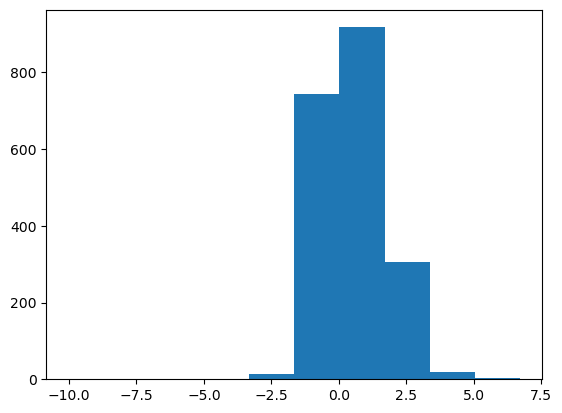

In [18]:
plt.hist(encoded_data[:,3])

In [19]:
from IPython.lib.display import Audio

framerate = 4410
play_time_seconds = 1
t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t)
Audio(audio_data, rate=framerate, autoplay=True)